In [10]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
import pandas as pd
import os
import numpy as np
ROOT_DIR = "../../"

def parse_results(results_file: str):
    with open(results_file, 'r') as f:
        lines = f.readlines()

    run_times = {}  
    compile_times = {}   #indexed by 2 strings: benchmark name and optimisation name
    lines_of_code = {}  #does not include GFortran
    current_benchmark = None
    current_optimisation = None

    index = 0  # Initialize an index to track the current line

    while index < len(lines):
        line = lines[index]
        if line.startswith("Benchmark:"):
            current_benchmark = line.split(":")[1].strip()

            if current_benchmark not in run_times:
                run_times[current_benchmark] = {}
            if current_benchmark not in compile_times:
                compile_times[current_benchmark] = {}
            if current_benchmark not in lines_of_code:
                lines_of_code[current_benchmark] = {}
           
        elif line.startswith("Optimisation:"):
            parts = line.split(":")
            if len(parts) > 1:
                current_optimisation = parts[1].strip()#.lstrip('-')
                if current_optimisation == "":
                    current_optimisation = "None"
                # if current_optimisation == "-iterCSE-CP -iterPRE-CP -const -DCE -simplify":
                    # current_optimisation = "All"
                
            run_times[current_benchmark][current_optimisation] = []     #should not exist yet - add empty list
            compile_times[current_benchmark][current_optimisation] = []

        elif line.startswith("Lines of code:"):
            index += 1  # Move to the next line after "Lines of code:"
            loc = int(lines[index].strip())
            lines_of_code[current_benchmark][current_optimisation] = loc
            continue  # Skip the rest of the loop to avoid incrementing index again

        elif line.startswith("Run times:"):
            index += 1  # Move to the next line after "Run times:"
            # Start reading run times
            while index < len(lines) and not lines[index].startswith("Compile times:"):
                run_times[current_benchmark][current_optimisation].append(float(lines[index].strip()))
                index += 1  # Advance the index
            continue  # Skip the rest of the loop to avoid incrementing index again
        elif line.startswith("Compile times:"):
            index += 1  # Move to the next line after "Compile times:"
            # Start reading compile times
            while index < len(lines) and not lines[index].startswith("----"):
                compile_times[current_benchmark][current_optimisation].append(float(lines[index].strip()))
                index += 1  # Advance the index
            continue  # Skip the rest of the loop to avoid incrementing index again
        index += 1  # Move to the next line for the main loop

    # Handle cases where run_times or compile_times might be empty
    return run_times, compile_times, lines_of_code

# def get_average_times(times_dict: dict):
#     for benchmark in times_dict:
#         for optimisation in times_dict[benchmark]:
#             times_dict[benchmark][optimisation] = sum(times_dict[benchmark][optimisation]) / len(times_dict[benchmark][optimisation])
#     return times_dict

def get_average_times(times_dict: dict):
    for benchmark in times_dict:
        for optimisation in times_dict[benchmark]:
            # Convert to numpy array for median calculation
            # times_dict[benchmark][optimisation] = np.array(times_dict[benchmark][optimisation])
            # Calculate the median of the times
            times_dict[benchmark][optimisation] = np.median(times_dict[benchmark][optimisation])
    return times_dict
    # return np.median(times_dict, axis=1)

# def draw_bar_chart(times_dict: dict):
#     for benchmark in times_dict:
#         for optimisation in times_dict[benchmark]:
#             plt.bar(optimisation, times_dict[benchmark][optimisation])
#     plt.show()


#plots the average run and compile times for each benchmark
def draw_bar_chart(run_times_dict: dict, compile_times_dict: dict, save_plot_path: str):
    benchmarks = list(run_times_dict.keys())
    num_benchmarks = len(benchmarks)
    
    # Create a figure with subplots
    fig, axs = plt.subplots(num_benchmarks, 2, figsize=(12, 5 * num_benchmarks))
    
    for i, benchmark in enumerate(benchmarks):
        # Get the correct axes based on number of benchmarks
        if num_benchmarks == 1:
            ax_run = axs[0]
            ax_compile = axs[1]
        else:
            ax_run = axs[i, 0]
            ax_compile = axs[i, 1]

        # Plot run times
        optimisations = list(run_times_dict[benchmark].keys())
        run_times = list(run_times_dict[benchmark].values())

        # colors = cm.mako(np.linspace(0.2, 0.8, len(optimisations)))  # Generate colors based on the number of optimisations
        colors = sns.color_palette("mako", len(optimisations))
        ax_run.bar(optimisations, run_times, color=colors)
        ax_run.set_title(f'Run Times for {benchmark}')
        ax_run.set_ylabel('Time (s)')
        ax_run.set_xlabel('Optimisation')
        ax_run.set_ylim(bottom=0)  # Set the lower limit to 0
        ax_run.set_ylim(top=max(run_times) * 1.1)  # Set the upper limit to 10% above the max run time
        ax_run.tick_params(axis='x', rotation=45)
        
        # Plot compile times
        
        compile_times = list(compile_times_dict[benchmark].values())
        ax_compile.bar(optimisations, compile_times, color=colors)
        ax_compile.set_title(f'Compile Times for {benchmark}')
        ax_compile.set_ylabel('Time (s)')
        ax_compile.set_xlabel('Optimisation')
        ax_compile.set_ylim(bottom=0)  # Set the lower limit to 0
        ax_compile.set_ylim(top=max(compile_times) * 1.1)  # Set the upper limit to 10% above the max compile time
        ax_compile.tick_params(axis='x', rotation=45)
    plt.tight_layout()

    # Save the figure if a save path is provided
    if save_plot_path:
        plt.savefig(save_plot_path, dpi=300, bbox_inches='tight')
    

    plt.show()


def plot_compile_times(all_compile_times: dict, save_dir: str):
    benchmarks = list(all_compile_times.keys())

    # different_colours = ["Reds","Blues", ["#A9C9B6","#3F6C51","#183926"], ["#FDDEAD","#DD9219"], ["#D5B5CB", "#824670", "#532B47"]]
  

    different_colours = [["#A9C9B6", "#3F6C51","#EBCDD5", "#183926", "#cc7589"]]
    
    for i, benchmark in enumerate(benchmarks):
        plt.figure(figsize=(8, 6))
        opt_compile_times = all_compile_times[benchmark]
        optimisations = list(opt_compile_times.keys())
        compile_times = list(opt_compile_times.values())

        median_times = np.median(compile_times, axis=1)
        iqr_low = median_times - np.percentile(compile_times, 25, axis=1)  # Q1 - Median
        iqr_high = np.percentile(compile_times, 75, axis=1) - median_times  # Q3 - Median
        yerr = [iqr_low, iqr_high]

        # colors = sns.color_palette("mako", len(optimisations))
        colors = []
        for opt in optimisations:
            if opt == 'GFortran':
                colors.append('#992D7F')  # purple
            else:
                # colors.append(sns.color_palette("Greys", len(optimisations))[optimisations.index(opt)])
                colors.append(sns.color_palette(different_colours[i], len(optimisations))[optimisations.index(opt)])

        plt.bar(optimisations, median_times, yerr=yerr, capsize=12, color=colors)
        xticks = plt.xticks(rotation=35, ha='center', fontsize=16)
        # xticks[1][0].set_color(colors[0])
        plt.yticks(fontsize=12)

        plt.ylabel('Compile Time (ms)', labelpad=10, fontsize=16)
        plt.xlabel('Compiler Configuration', fontsize=16)
        # plt.title(f'{benchmark}')
        plt.tight_layout()

        if save_dir:
            os.makedirs(save_dir, exist_ok=True)
            save_path = os.path.join(save_dir, f'compile_times_{benchmark}.png')
            plt.savefig(save_path, dpi=300, bbox_inches='tight')
        
        plt.show()

def plot_run_times(all_run_times: dict, save_dir: str):
    benchmarks = list(all_run_times.keys())

    # different_colours = ["Reds","Blues", ["#8AC2A0","#3F6C51","#183926"], ["#FDDEAD","#DD9219"], ["#C69BB9", "#824670", "#532B47"]]
    different_colours = [["#A9C9B6", "#3F6C51","#EBCDD5", "#183926", "#cc7589"]]
    # different_colours = ["Reds","Blues", "light:#183926", "light:#DD9219", "light:#532B47"]

    for i, benchmark in enumerate(benchmarks):
        plt.figure(figsize=(8,6))
        opt_run_times = all_run_times[benchmark]
        optimisations = list(opt_run_times.keys())
        run_times = list(opt_run_times.values())

        median_times = np.median(run_times, axis=1)
        iqr_low = median_times - np.percentile(run_times, 25, axis=1)  # Q1 - Median
        iqr_high = np.percentile(run_times, 75, axis=1) - median_times  # Q3 - Median
        yerr = [iqr_low, iqr_high]

        colors = []
        for opt in optimisations:
            if opt == 'GFortran':
                colors.append('#992D7F')  # purple
            else:
                colors.append(sns.color_palette(different_colours[i], len(optimisations))[optimisations.index(opt)])

        plt.bar(optimisations, median_times, yerr=yerr, capsize=12, color=colors)
        xticks = plt.xticks(rotation=35, ha='center', fontsize=16)
        plt.yticks(fontsize=12)
        # xticks[1][0].set_color(colors[0])    #set Gfortran colour to match the purple
     
        plt.ylabel('Run Time (ms)', labelpad=10, fontsize=16)
        plt.xlabel('Compiler Configuration', fontsize=16)
        # plt.title(f'{benchmark}')
        plt.tight_layout()

        if save_dir:
            os.makedirs(save_dir, exist_ok=True)
            save_path = os.path.join(save_dir, f'run_times_{benchmark}.png')
            plt.savefig(save_path, dpi=300, bbox_inches='tight')
        
        plt.show()
 

def plot_lines_of_code(lines_of_code: dict, save_dir: str):
    benchmarks = list(lines_of_code.keys())

    different_colours = ["Reds","Blues", ["#A9C9B6","#3F6C51","#183926"], ["#FDDEAD","#DD9219"], ["#D5B5CB", "#824670", "#532B47"]]

    for i, benchmark in enumerate(benchmarks):
        plt.figure(figsize=(5.5, 6))
        opt_lines_of_code = lines_of_code[benchmark]
        optimisations = list(opt_lines_of_code.keys())
        loc_values = list(opt_lines_of_code.values())
        
        colors = sns.color_palette(different_colours[i], len(optimisations))
        
        # Plot just dots (no stems)
        plt.scatter(optimisations, loc_values, color=colors, s=100)
        
        # Add value labels
        for i, value in enumerate(loc_values):
            plt.text(i, value + (max(loc_values)*1.1-min(loc_values)*0.9)*0.025, f'{value}',
                     ha='center', va='bottom', fontsize=22)
        
        # Adjust y-axis to zoom in (remove padding and focus on data range)
        plt.ylim(min(loc_values) * 0.9, max(loc_values) * 1.1)  # 10% padding
        plt.xlim(-0.5, len(optimisations) - 0.5)  # Add 0.5 padding on both sides
        
        plt.xticks(rotation=35, ha='center', fontsize=20)
        plt.yticks(fontsize=16)
        plt.ylabel('Lines of Code', labelpad=10, fontsize=20)
        plt.xlabel('Compiler Optimisation', fontsize=20)
        # plt.title(f'{benchmark}')
        plt.tight_layout()

        if save_dir:
            os.makedirs(save_dir, exist_ok=True)
            save_path = os.path.join(save_dir, f'lines_of_code_{benchmark}.png')
            plt.savefig(save_path, dpi=300, bbox_inches='tight')
        
        plt.show()

        
     
        

In [12]:
def main():
    experiment_number = 51
    results_file = ROOT_DIR + "scripts/benchmark/results/exp" + str(experiment_number) + f"/benchmark_results_{str(experiment_number)}.txt"
    save_dir = ROOT_DIR + "scripts/benchmark/results/exp" + str(experiment_number) 
    save_plot_path = save_dir+ f"/benchmark_plot_{str(experiment_number)}.png"

    
    run_times, compile_times, lines_of_code = parse_results(results_file)
    # avg_run_times = get_average_times(run_times)
   
    # print(avg_run_times)
    
    # draw_bar_chart(avg_run_times, avg_compile_times, save_plot_path)
    # print(compile_times)
    # print(lines_of_code)
    # plot_compile_times(compile_times, save_dir+f"/compile_times_micro")
    # plot_run_times(run_times, save_dir+f"/run_times_micro")
    # plot_lines_of_code(lines_of_code, save_dir+f"/lines_of_code_micro2")
    avg_compile_times = get_average_times(compile_times)
    print(avg_compile_times)
    avg_run_times = get_average_times(run_times)
    print(avg_run_times)
    print(lines_of_code)
    

if __name__ == "__main__":
    main()

{'partialredundancy': {'None': np.float64(146.0079345703125), '-PRE': np.float64(1302.476318359375), '-PRE-2.0': np.float64(526.4781494140625), '-iterPRE-CP': np.float64(5919.9989013671875), '-iterPRE-CP-2.0': np.float64(2026.3326416015625)}}
{'partialredundancy': {'None': np.float64(13601.548812), '-PRE': np.float64(11185.6850625), '-PRE-2.0': np.float64(11349.1600415), '-iterPRE-CP': np.float64(6690.972229), '-iterPRE-CP-2.0': np.float64(6755.430854)}}
{'partialredundancy': {'None': 136, '-PRE': 134, '-PRE-2.0': 134, '-iterPRE-CP': 124, '-iterPRE-CP-2.0': 124}}


In [ ]:
#GOOD FOR MICROBENCHMARKS

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
import pandas as pd
import os
import numpy as np
ROOT_DIR = "../../"

def parse_results(results_file: str):
    with open(results_file, 'r') as f:
        lines = f.readlines()

    run_times = {}  
    compile_times = {}   #indexed by 2 strings: benchmark name and optimisation name
    lines_of_code = {}  #does not include GFortran
    current_benchmark = None
    current_optimisation = None

    index = 0  # Initialize an index to track the current line

    while index < len(lines):
        line = lines[index]
        if line.startswith("Benchmark:"):
            current_benchmark = line.split(":")[1].strip()

            if current_benchmark not in run_times:
                run_times[current_benchmark] = {}
            if current_benchmark not in compile_times:
                compile_times[current_benchmark] = {}
            if current_benchmark not in lines_of_code:
                lines_of_code[current_benchmark] = {}
           
        elif line.startswith("Optimisation:"):
            parts = line.split(":")
            if len(parts) > 1:
                current_optimisation = parts[1].strip()#.lstrip('-')
                if current_optimisation == "":
                    current_optimisation = "None"
                # if current_optimisation == "-iterCSE-CP -iterPRE-CP -const -DCE -simplify":
                    # current_optimisation = "All"
                
            run_times[current_benchmark][current_optimisation] = []     #should not exist yet - add empty list
            compile_times[current_benchmark][current_optimisation] = []

        elif line.startswith("Lines of code:"):
            index += 1  # Move to the next line after "Lines of code:"
            loc = int(lines[index].strip())
            lines_of_code[current_benchmark][current_optimisation] = loc
            continue  # Skip the rest of the loop to avoid incrementing index again

        elif line.startswith("Run times:"):
            index += 1  # Move to the next line after "Run times:"
            # Start reading run times
            while index < len(lines) and not lines[index].startswith("Compile times:"):
                run_times[current_benchmark][current_optimisation].append(float(lines[index].strip()))
                index += 1  # Advance the index
            continue  # Skip the rest of the loop to avoid incrementing index again
        elif line.startswith("Compile times:"):
            index += 1  # Move to the next line after "Compile times:"
            # Start reading compile times
            while index < len(lines) and not lines[index].startswith("----"):
                compile_times[current_benchmark][current_optimisation].append(float(lines[index].strip()))
                index += 1  # Advance the index
            continue  # Skip the rest of the loop to avoid incrementing index again
        index += 1  # Move to the next line for the main loop

    # Handle cases where run_times or compile_times might be empty
    return run_times, compile_times, lines_of_code

# def get_average_times(times_dict: dict):
#     for benchmark in times_dict:
#         for optimisation in times_dict[benchmark]:
#             times_dict[benchmark][optimisation] = sum(times_dict[benchmark][optimisation]) / len(times_dict[benchmark][optimisation])
#     return times_dict

def get_average_times(times_dict: dict):
    for benchmark in times_dict:
        for optimisation in times_dict[benchmark]:
            # Convert to numpy array for median calculation
            # times_dict[benchmark][optimisation] = np.array(times_dict[benchmark][optimisation])
            # Calculate the median of the times
            times_dict[benchmark][optimisation] = np.median(times_dict[benchmark][optimisation])
    return times_dict
    # return np.median(times_dict, axis=1)

# def draw_bar_chart(times_dict: dict):
#     for benchmark in times_dict:
#         for optimisation in times_dict[benchmark]:
#             plt.bar(optimisation, times_dict[benchmark][optimisation])
#     plt.show()


#plots the average run and compile times for each benchmark
def draw_bar_chart(run_times_dict: dict, compile_times_dict: dict, save_plot_path: str):
    benchmarks = list(run_times_dict.keys())
    num_benchmarks = len(benchmarks)
    
    # Create a figure with subplots
    fig, axs = plt.subplots(num_benchmarks, 2, figsize=(12, 5 * num_benchmarks))
    
    for i, benchmark in enumerate(benchmarks):
        # Get the correct axes based on number of benchmarks
        if num_benchmarks == 1:
            ax_run = axs[0]
            ax_compile = axs[1]
        else:
            ax_run = axs[i, 0]
            ax_compile = axs[i, 1]

        # Plot run times
        optimisations = list(run_times_dict[benchmark].keys())
        run_times = list(run_times_dict[benchmark].values())

        # colors = cm.mako(np.linspace(0.2, 0.8, len(optimisations)))  # Generate colors based on the number of optimisations
        colors = sns.color_palette("mako", len(optimisations))
        ax_run.bar(optimisations, run_times, color=colors)
        ax_run.set_title(f'Run Times for {benchmark}')
        ax_run.set_ylabel('Time (s)')
        ax_run.set_xlabel('Optimisation')
        ax_run.set_ylim(bottom=0)  # Set the lower limit to 0
        ax_run.set_ylim(top=max(run_times) * 1.1)  # Set the upper limit to 10% above the max run time
        ax_run.tick_params(axis='x', rotation=45)
        
        # Plot compile times
        
        compile_times = list(compile_times_dict[benchmark].values())
        ax_compile.bar(optimisations, compile_times, color=colors)
        ax_compile.set_title(f'Compile Times for {benchmark}')
        ax_compile.set_ylabel('Time (s)')
        ax_compile.set_xlabel('Optimisation')
        ax_compile.set_ylim(bottom=0)  # Set the lower limit to 0
        ax_compile.set_ylim(top=max(compile_times) * 1.1)  # Set the upper limit to 10% above the max compile time
        ax_compile.tick_params(axis='x', rotation=45)
    plt.tight_layout()

    # Save the figure if a save path is provided
    if save_plot_path:
        plt.savefig(save_plot_path, dpi=300, bbox_inches='tight')
    

    plt.show()


def plot_compile_times(all_compile_times: dict, save_dir: str):
    benchmarks = list(all_compile_times.keys())

    different_colours = ["Reds","Blues", ["#A9C9B6","#3F6C51","#183926"], ["#FDDEAD","#DD9219"], ["#D5B5CB", "#824670", "#532B47"]]

    for i, benchmark in enumerate(benchmarks):
        plt.figure(figsize=(5.5, 6))
        opt_compile_times = all_compile_times[benchmark]
        optimisations = list(opt_compile_times.keys())
        compile_times = list(opt_compile_times.values())

        median_times = np.median(compile_times, axis=1)
        iqr_low = median_times - np.percentile(compile_times, 25, axis=1)  # Q1 - Median
        iqr_high = np.percentile(compile_times, 75, axis=1) - median_times  # Q3 - Median
        yerr = [iqr_low, iqr_high]

        # colors = sns.color_palette("mako", len(optimisations))
        colors = []
        for opt in optimisations:
            if opt == 'GFortran':
                colors.append('#992D7F')  # purple
            else:
                # colors.append(sns.color_palette("Greys", len(optimisations))[optimisations.index(opt)])
                colors.append(sns.color_palette(different_colours[i], len(optimisations))[optimisations.index(opt)])

        plt.bar(optimisations, median_times, yerr=yerr, capsize=12, color=colors)
        xticks = plt.xticks(rotation=35, ha='center', fontsize=20)
        # xticks[1][0].set_color(colors[0])
        plt.yticks(fontsize=16)

        plt.ylabel('Compile Time (ms)', labelpad=10, fontsize=20)
        plt.xlabel('Compiler Configuration', fontsize=20)
        # plt.title(f'{benchmark}')
        plt.tight_layout()

        if save_dir:
            os.makedirs(save_dir, exist_ok=True)
            save_path = os.path.join(save_dir, f'compile_times_{benchmark}.png')
            plt.savefig(save_path, dpi=300, bbox_inches='tight')
        
        plt.show()

def plot_run_times(all_run_times: dict, save_dir: str):
    benchmarks = list(all_run_times.keys())

    # different_colours = ["Reds","Blues", ["#8AC2A0","#3F6C51","#183926"], ["#FDDEAD","#DD9219"], ["#C69BB9", "#824670", "#532B47"]]
    different_colours = ["Reds","Blues", ["#A9C9B6","#3F6C51","#183926"], ["#FDDEAD","#DD9219"], ["#D5B5CB", "#824670", "#532B47"]]
    # different_colours = ["Reds","Blues", "light:#183926", "light:#DD9219", "light:#532B47"]

    for i, benchmark in enumerate(benchmarks):
        plt.figure(figsize=(5.5,6))
        opt_run_times = all_run_times[benchmark]
        optimisations = list(opt_run_times.keys())
        run_times = list(opt_run_times.values())

        median_times = np.median(run_times, axis=1)
        iqr_low = median_times - np.percentile(run_times, 25, axis=1)  # Q1 - Median
        iqr_high = np.percentile(run_times, 75, axis=1) - median_times  # Q3 - Median
        yerr = [iqr_low, iqr_high]

        colors = []
        for opt in optimisations:
            if opt == 'GFortran':
                colors.append('#992D7F')  # purple
            else:
                colors.append(sns.color_palette(different_colours[i], len(optimisations))[optimisations.index(opt)])

        plt.bar(optimisations, median_times, yerr=yerr, capsize=12, color=colors)
        xticks = plt.xticks(rotation=35, ha='center', fontsize=20)
        plt.yticks(fontsize=16)
        # xticks[1][0].set_color(colors[0])    #set Gfortran colour to match the purple
     
        plt.ylabel('Run Time (ms)', labelpad=10, fontsize=20)
        plt.xlabel('Compiler Configuration', fontsize=20)
        # plt.title(f'{benchmark}')
        plt.tight_layout()

        if save_dir:
            os.makedirs(save_dir, exist_ok=True)
            save_path = os.path.join(save_dir, f'run_times_{benchmark}.png')
            plt.savefig(save_path, dpi=300, bbox_inches='tight')
        
        plt.show()
 

def plot_lines_of_code(lines_of_code: dict, save_dir: str):
    benchmarks = list(lines_of_code.keys())

    different_colours = ["Reds","Blues", ["#A9C9B6","#3F6C51","#183926"], ["#FDDEAD","#DD9219"], ["#D5B5CB", "#824670", "#532B47"]]

    for i, benchmark in enumerate(benchmarks):
        plt.figure(figsize=(5.5, 6))
        opt_lines_of_code = lines_of_code[benchmark]
        optimisations = list(opt_lines_of_code.keys())
        loc_values = list(opt_lines_of_code.values())
        
        colors = sns.color_palette(different_colours[i], len(optimisations))
        
        # Plot just dots (no stems)
        plt.scatter(optimisations, loc_values, color=colors, s=100)
        
        # Add value labels
        for i, value in enumerate(loc_values):
            plt.text(i, value + (max(loc_values)*1.1-min(loc_values)*0.9)*0.025, f'{value}',
                     ha='center', va='bottom', fontsize=22)
        
        # Adjust y-axis to zoom in (remove padding and focus on data range)
        plt.ylim(min(loc_values) * 0.9, max(loc_values) * 1.1)  # 10% padding
        plt.xlim(-0.5, len(optimisations) - 0.5)  # Add 0.5 padding on both sides
        
        plt.xticks(rotation=35, ha='center', fontsize=20)
        plt.yticks(fontsize=16)
        plt.ylabel('Lines of Code', labelpad=10, fontsize=20)
        plt.xlabel('Compiler Optimisation', fontsize=20)
        # plt.title(f'{benchmark}')
        plt.tight_layout()

        if save_dir:
            os.makedirs(save_dir, exist_ok=True)
            save_path = os.path.join(save_dir, f'lines_of_code_{benchmark}.png')
            plt.savefig(save_path, dpi=300, bbox_inches='tight')
        
        plt.show()

        
     
        

In [ ]:
def main():
    experiment_number = 47
    results_file = ROOT_DIR + "scripts/benchmark/results/exp" + str(experiment_number) + f"/benchmark_results_{str(experiment_number)}.txt"
    save_dir = ROOT_DIR + "scripts/benchmark/results/exp" + str(experiment_number) 
    save_plot_path = save_dir+ f"/benchmark_plot_{str(experiment_number)}.png"

    
    run_times, compile_times, lines_of_code = parse_results(results_file)
    # avg_run_times = get_average_times(run_times)
   
    # print(avg_run_times)
    
    # draw_bar_chart(avg_run_times, avg_compile_times, save_plot_path)
    # print(compile_times)
    # print(lines_of_code)
    plot_compile_times(compile_times, save_dir+f"/compile_times_micro2")
    plot_run_times(run_times, save_dir+f"/run_times_micro2")
    plot_lines_of_code(lines_of_code, save_dir+f"/lines_of_code_micro2")
    # avg_compile_times = get_average_times(compile_times)
    # print(avg_compile_times)
    # avg_run_times = get_average_times(run_times)
    # print(avg_run_times)
    # print(lines_of_code)
    

if __name__ == "__main__":
    main()

In [21]:
#good for the macro


def plot_compile_times(all_compile_times: dict, save_dir: str):
    benchmarks = list(all_compile_times.keys())


    for benchmark in benchmarks:
        plt.figure(figsize=(6, 6))
        opt_compile_times = all_compile_times[benchmark]
        optimisations = list(opt_compile_times.keys())
        compile_times = list(opt_compile_times.values())

        median_times = np.median(compile_times, axis=1)
        # iqr_low = median_times - np.percentile(compile_times, 25, axis=1)  # Q1 - Median
        # iqr_high = np.percentile(compile_times, 75, axis=1) - median_times  # Q3 - Median
        # yerr = [iqr_low, iqr_high]
        mins = np.min(compile_times, axis=1)
        maxs = np.max(compile_times, axis=1)

        lower = median_times - mins
        upper = maxs - median_times
        yerr = [lower, upper]  # for asymmetric error bars

        # colors = sns.color_palette("mako", len(optimisations))
        colors = []
        for opt in optimisations:
            if opt == 'GFortran':
                colors.append('#992D7F')  # purple
            else:
                colors.append(sns.color_palette("mako", len(optimisations))[optimisations.index(opt)])

        plt.bar(optimisations, median_times, yerr=yerr, capsize=5, color=colors)
        xticks = plt.xticks(rotation=90, ha='center')
        xticks[1][0].set_color(colors[0])

        plt.ylabel('Compile Time (ms)', labelpad=10)
        plt.xlabel('Compiler Configuration')
        # plt.title(f'{benchmark}')
        plt.tight_layout()

        if save_dir:
            os.makedirs(save_dir, exist_ok=True)
            save_path = os.path.join(save_dir, f'compile_times_{benchmark}.png')
            plt.savefig(save_path, dpi=300, bbox_inches='tight')
        
        plt.show()

def plot_run_times(all_run_times: dict, save_dir: str):
    benchmarks = list(all_run_times.keys())

    for i, benchmark in enumerate(benchmarks):
        plt.figure(figsize=(6, 6))
        opt_run_times = all_run_times[benchmark]
        optimisations = list(opt_run_times.keys())
        run_times = list(opt_run_times.values())

        median_times = np.median(run_times, axis=1)
        iqr_low = median_times - np.percentile(run_times, 25, axis=1)  # Q1 - Median
        iqr_high = np.percentile(run_times, 75, axis=1) - median_times  # Q3 - Median
        yerr = [iqr_low, iqr_high]

        colors = []
        for opt in optimisations:
            if opt == 'GFortran':
                colors.append('#992D7F')  # purple
            else:
                colors.append(sns.color_palette("mako", len(optimisations))[optimisations.index(opt)])

        plt.bar(optimisations, median_times, yerr=yerr, capsize=5, color=colors)
        xticks = plt.xticks(rotation=90, ha='center')
        xticks[1][0].set_color(colors[0])    #set Gfortran colour to match the purple
     
        plt.ylabel('Run Time (ms)', labelpad=10)
        plt.xlabel('Compiler Configuration')
        # plt.title(f'{benchmark}')
        plt.tight_layout()

        if save_dir:
            os.makedirs(save_dir, exist_ok=True)
            save_path = os.path.join(save_dir, f'run_times_{benchmark}.png')
            plt.savefig(save_path, dpi=300, bbox_inches='tight')
        
        plt.show()


def plot_lines_of_code(lines_of_code: dict, save_dir: str):
    benchmarks = list(lines_of_code.keys())


    for i, benchmark in enumerate(benchmarks):
        plt.figure(figsize=(6, 6))
        opt_lines_of_code = lines_of_code[benchmark]
        optimisations = list(opt_lines_of_code.keys())
        loc_values = list(opt_lines_of_code.values())
        
        colors = sns.color_palette("mako", len(optimisations))
        
        # Plot just dots (no stems)
        plt.scatter(optimisations, loc_values, color=colors, s=100)
        
        # Add value labels
        for i, value in enumerate(loc_values):
            plt.text(i, value + (max(loc_values)*1.1-min(loc_values)*0.9)*0.025, f'{value}',
                     ha='center', va='bottom', fontsize=9)
        
        # Adjust y-axis to zoom in (remove padding and focus on data range)
        plt.ylim(min(loc_values) * 0.9, max(loc_values) * 1.1)  # 10% padding
        
        plt.xticks(rotation=90, ha='center')
        plt.ylabel('Lines of Code', labelpad=10)
        plt.xlabel('Compiler Optimisation')
        # plt.title(f'{benchmark}')
        plt.tight_layout()

        if save_dir:
            os.makedirs(save_dir, exist_ok=True)
            save_path = os.path.join(save_dir, f'lines_of_code_{benchmark}.png')
            plt.savefig(save_path, dpi=300, bbox_inches='tight')
        
        plt.show()

        
     
        

In [34]:
def main():
    experiment_number = 41
    results_file = ROOT_DIR + "scripts/benchmark/results/exp" + str(experiment_number) + f"/benchmark_results_{str(experiment_number)}.txt"
    save_dir = ROOT_DIR + "scripts/benchmark/results/exp" + str(experiment_number) 
    save_plot_path = save_dir+ f"/benchmark_plot_{str(experiment_number)}.png"

    
    run_times, compile_times, lines_of_code = parse_results(results_file)
    # avg_run_times = get_average_times(run_times)
    # avg_compile_times = get_average_times(compile_times)
    # print(avg_run_times)
    # print(avg_compile_times)
    # draw_bar_chart(avg_run_times, avg_compile_times, save_plot_path)
    # print(compile_times)
    # print(lines_of_code)
    # plot_compile_times(compile_times, save_dir+f"/compile_times3")
    # plot_run_times(run_times, save_dir+f"/run_times3")
    # plot_lines_of_code(lines_of_code, save_dir+f"/lines_of_code3")
    avg_run_times = get_average_times(run_times)
    avg_compile_times = get_average_times(compile_times)
    
    print(avg_compile_times)
    print(avg_run_times)

    # print(lines_of_code)
    

if __name__ == "__main__":
    main()

{'sieveOfErat': {'GFortran': np.float64(75.8525390625), 'None': np.float64(93.445556640625), '-DCE': np.float64(97.8590087890625), '-CSE': np.float64(120.1070556640625), '-PRE': np.float64(386.431884765625), '-CP': np.float64(96.3123779296875), '-const': np.float64(98.2425537109375), '-simplify': np.float64(94.6767578125), '-DCE -simplify': np.float64(113.7794189453125), '-iterCSE-CP': np.float64(151.1820068359375), '-iterPRE-CP': np.float64(680.382568359375), '-iterCSE-CP -DCE': np.float64(150.3609619140625), '-iterPRE-CP -DCE': np.float64(673.0325927734375), 'All': np.float64(436.0667724609375)}, 'taylorSeries': {'GFortran': np.float64(72.96337890625), 'None': np.float64(198.45458984375), '-DCE': np.float64(224.472900390625), '-CSE': np.float64(5161.892578125), '-PRE': np.float64(37142.321044921875), '-CP': np.float64(211.7169189453125), '-const': np.float64(211.801513671875), '-simplify': np.float64(203.2874755859375), '-DCE -simplify': np.float64(212.697021484375), '-iterCSE-CP': n

In [60]:
#good for the phase ordering
from matplotlib.lines import Line2D

def combine_results(all_compile_times: dict, all_run_times: dict, all_lines_of_code: dict):  #each is dictionary of benchmark : {optimisation : [times]}
    #return a dict of benchmark : {optimisation: [[compile times], [run times], [lines of code]]}
    combined_results = {}
    
    for benchmark in all_compile_times.keys():
        index = 0
        combined_results[benchmark] = {}
        for optimisation in all_compile_times[benchmark].keys():
            # print(optimisation)
            if optimisation != "None":
                indexed_optimisation =  f"[{index}] " + optimisation 
                combined_results[benchmark][indexed_optimisation] = [
                    all_compile_times[benchmark][optimisation],
                    all_run_times[benchmark][optimisation],
                    all_lines_of_code[benchmark][optimisation]
                ]
                index+=1
                
    return combined_results

def convert_to_dataframe(benchmark_combined_results:dict):     # for one benchmark program, {optimisation ordering: [[compile times], [run times], [lines of code]]}
    #convert to
#     data = {
#     "Sequence": ["order1", "order1", "order1", "order2", "order2", "order2", "order3", "order3", "order3"],
#     "Compile time": [1.2, 1.1, 4.0, 1.3, 5.3, 2.1, 3.2, 4.3, 1.0]
#     "Runtime": [1.2, 1.1, 4.0, 1.3, 5.3, 2.1, 3.2, 4.3, 1.0]
#     "Lines of code": [10, 10, 10, 10, 10, 10, 10, 10, 10]
# }
    data = {"Phase ordering": [], "Compile time": [], "Runtime": [], "LOC": []}
    for ordering in benchmark_combined_results.keys():
        num_runs = len(benchmark_combined_results[ordering][0])
        for i in range(num_runs):
            data["Phase ordering"].append(ordering)
            data["Compile time"].append(benchmark_combined_results[ordering][0][i])
            data["Runtime"].append(benchmark_combined_results[ordering][1][i])
            data["LOC"].append(benchmark_combined_results[ordering][2])  #just a single value for LOC
    
    df = pd.DataFrame(data)

    # # Normalize the three metrics independently (min-max scaling)
    # for col in ["Compile time", "Runtime", "LOC"]:
    #     min_val = df[col].min()
    #     max_val = df[col].max()
    #     if max_val != min_val:
    #         df[col] = (df[col] - min_val) / (max_val - min_val)
    #     else:
    #         df[col] = 0.5  # or 1.0 — all values identical, so pick any constant

    # Normalize compile time and runtime relative to median
    for col in ["Compile time", "Runtime", "LOC"]:
        median_val = df[col].median()
        # mean_val = df[col].mean()
        if median_val != 0:
            df[col] = df[col] / median_val
        else:
            df[col] = 0.0  # or 1.0 — all values identical, so pick any constant

    return df

def plot_combined_results(combined_results: dict, save_dir: str):     #benchmark : {optimisation: [[compile times], [run times], [lines of code]]}
    #plot a grouped horizontal bar chart, grouped by optimisation, each has 3 bars: compile time, run time, lines of code

    benchmarks = list(combined_results.keys())
    phase_orderings = list(combined_results[benchmarks[0]].keys())

    for benchmark_program in benchmarks:
        plt.figure(figsize=(12, 6))
        df = convert_to_dataframe(combined_results[benchmark_program])
        df_melted = pd.melt(
            df, 
            id_vars="Phase ordering", 
            value_vars=["Runtime", "Compile time", "LOC"],
            var_name="Metric", 
            value_name="Value",
            
        )
        colors = sns.color_palette("Greys", 3)[::-1]   #one for each metric
        # colors = sns.diverging_palette(145, 300, s=60, n=3)
        colors = [colors[0], colors[2], colors[1]]


        sns.barplot(data=df_melted, 
                    x="Value", 
                    y="Phase ordering", 
                    hue="Metric",  # Crucial for separating metrics
                    estimator=np.median,
                    errorbar = None,
                    # errorbar=('pi', 50),  # Explicit IQR (Q1-Q3)
                    capsize=0.2,
                    palette=colors)
        
        # plt.title(f"Optimization Results for {benchmark_program}")
        plt.axvline(x=1, color='#DD614A', linestyle='--')
        plt.xlabel("Median-Normalized Value", labelpad=12)
        plt.ylabel("Phase Ordering")
        plt.legend(title="Metric")
        plt.tight_layout()
        

        if save_dir:
            os.makedirs(save_dir, exist_ok=True)
            save_path = os.path.join(save_dir, f'combined_results_{benchmark_program}.png')
            plt.savefig(save_path, dpi=300, bbox_inches='tight')

        plt.show()
        


#plot 2 benchmarks on a single plot
def plot_combined_results2(combined_results: dict, save_dir: str):
    import matplotlib.pyplot as plt
    import seaborn as sns
    import os
    import pandas as pd
    import numpy as np

    benchmarks = list(combined_results.keys())
    assert len(benchmarks) == 2, "This function expects exactly 2 benchmark programs."

    # Set up side-by-side plots, sharing y-axis
    fig, axes = plt.subplots(1, 2, figsize=(16, 6), sharey=True)

    # Define and reorder color palette
    # colors = sns.color_palette("coolwarm", 3)[::-1]
    # colors = sns.color_palette("Greys", 3)[::-1]
    colors = ["#B2DED7", "#5483E1", "#2E2D48" ]
    # colors = [colors[0], colors[2], colors[1]]  # reorder so lightest is in the middle

    for i, benchmark_program in enumerate(reversed(benchmarks)):
        ax = axes[i]
        df = convert_to_dataframe(combined_results[benchmark_program])
        df_melted = pd.melt(
            df, 
            id_vars="Phase ordering", 
            value_vars=["Compile time", "Runtime", "LOC"],
            var_name="Metric", 
            value_name="Value",
        )

        sns.barplot(
            data=df_melted,
            x="Value",
            y="Phase ordering",
            hue="Metric",
            estimator=np.median,
            errorbar=None,
            capsize=0.2,
            palette=colors,
            ax=ax, 
        

        )

        # ax.set_title(f"{benchmark_program}")
        ax.set_xlabel("Median-Normalized Value", fontsize=12, labelpad=12)
        if i == 0:
            ax.set_title("partialRedundancy", fontsize=12)
            ax.set_ylabel("Phase Ordering", fontsize=12)
            ax.legend_.remove()
            yticks = ax.get_yticklabels()
            ax.set_yticklabels(yticks, fontsize=12)
            # yticks[0].set_color('#992D7F')    #the 'All' one that I used in the other plots
        else:
            ax.set_title("taylorSeries", fontsize=12)
            ax.set_ylabel("")  # Don't duplicate
            # ax.legend(title="Metric", loc="upper center", ncol=3)
            # Create a custom patch for the vertical line
            # Create a dashed line legend handle
            # median_line_handle = Line2D([0], [0], color='#DD614A', linestyle='--', label='Median Reference')
            median_line_handle = Line2D([0], [0], color='red', linestyle='--', label='Median Reference')

            # Get existing barplot handles and labels
            handles, labels = ax.get_legend_handles_labels()

            # Add the median line
            handles.append(median_line_handle)
            labels.append('Median Reference')

            # Reset the legend
            ax.legend(handles=handles, labels=labels, title="Metric", loc="upper right", ncol=1, fontsize=10)
        ax.axvline(x=1, color='red', linestyle='--')
        # ax.axvline(x=1, color='#DD614A', linestyle='--')

    # Shared legend outside plot
    # handles, labels = ax.get_legend_handles_labels()
    # fig.legend(handles, labels, title="Metric", loc="upper center", ncol=3)

    plt.tight_layout(rect=[0, 0, 1, 0.95])  # leave space for legend

    if save_dir:
        os.makedirs(save_dir, exist_ok=True)
        save_path = os.path.join(save_dir, 'combined_results_comparison.png')
        plt.savefig(save_path, dpi=300, bbox_inches='tight')

    plt.show()


        
     
        

/var/folders/yt/hyb5xm0d49l41gm67pc020km0000gn/T/ipykernel_53540/1357099341.py:164: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(yticks, fontsize=12)


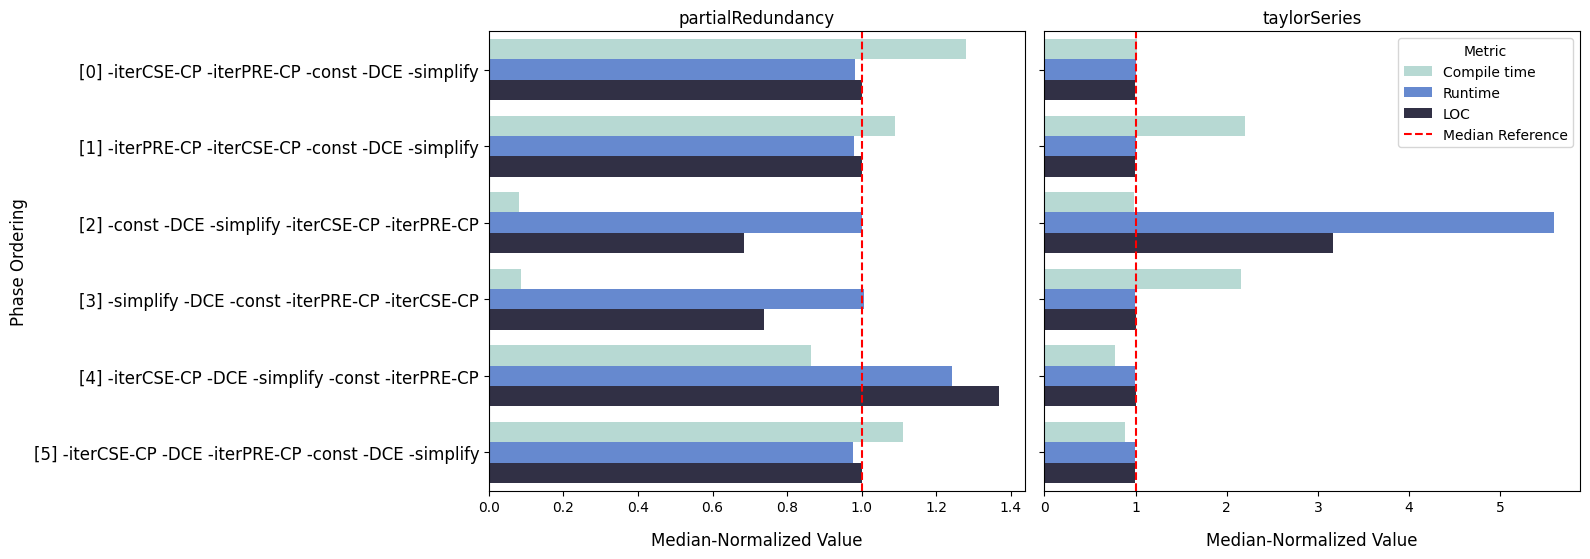

In [61]:
def main():
    experiment_number = 48
    results_file = ROOT_DIR + "scripts/benchmark/results/exp" + str(experiment_number) + f"/benchmark_results_{str(experiment_number)}.txt"
    save_dir = ROOT_DIR + "scripts/benchmark/results/exp" + str(experiment_number) 
    save_plot_path = save_dir+ f"/benchmark_plot_{str(experiment_number)}.png"

    
    run_times, compile_times, lines_of_code = parse_results(results_file)
    # avg_run_times = get_average_times(run_times)
    # avg_compile_times = get_average_times(compile_times)
    # print(avg_run_times)
    # print(avg_compile_times)
    # draw_bar_chart(avg_run_times, avg_compile_times, save_plot_path)
    # print(compile_times)
    combined_results = combine_results(compile_times, run_times, lines_of_code)
    plot_combined_results2(combined_results, save_dir+f"/combined_results21")
    # print(lines_of_code)
    # plot_compile_times(compile_times, save_dir+f"/compile_times")
    # plot_run_times(run_times, save_dir+f"/run_times")
    # plot_lines_of_code(lines_of_code, save_dir+f"/lines_of_code")

    # print(lines_of_code)
    

if __name__ == "__main__":
    main()